## **Bayesian Optimization**

Using `twinLab`, we can easily build a surrogate model of some real-world physical processes using limited experimental data. The discrepancy between this surrogate model and the real process is described by the (calibrated) uncertainty estimate produced our models. This way, inference activities while using the surrogate model can be supported by well-grounded evidence of the model _correctness_. In areas of high model uncertainty, one must then take care to not be overly trusting of the model output, which is especially important for safety-critical applications.

In some scenarios, there may be a requirement to find the value that maximizes an objective function(that is not available but we know this function generated the data points in our training data). `twinLab` offers the feature of finding the maximising values for a given function. This can be done once the model is fitted to the training data. The acquisition function `EI` (Expected Improvement) is used to find the value that maximizes an objective function using the Gaussian process trained on training data using `twinLab`.

This notebook will cover:

- Finding the maxima of an unknown function using `twinLab` from the data points generated by the unknown function.


In [1]:
# Third party imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# twinLab import
import twinlab as tl


          ====== TwinLab Client Initialisation ======
          Version     : 2.1.0
          Server      : https://twinlab.digilab.co.uk/dev
          Environment : /Users/sergiochavez/twinlab-demos/.env



### **1-Dimensional example**

We first begin with a one-dimensional example. Consider the following function:


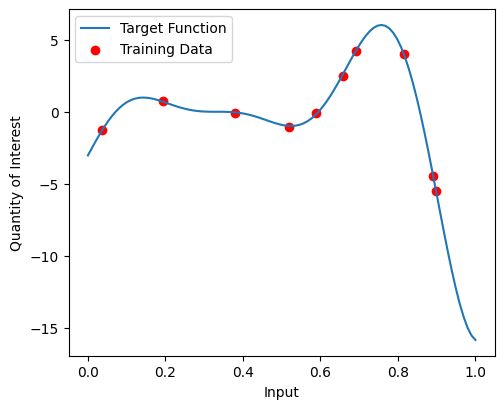

In [2]:
seed = 20
np.random.seed(seed)


# Target function: forrester function
def f(x, a=6, b=12):
    return -((a * x - 2) ** 2) * np.sin(b * x - 4)


X = np.linspace(0, 1, 100)[:, np.newaxis]
y = f(X)  # Arrange outputs as feature columns

# Set up training data dataframe
n_train = 10
X_data = np.random.uniform(0, 1, size=n_train)
y_data = f(X_data) + np.random.normal(scale=0.1, size=X_data.shape)

# Plot
plt.figure(figsize=(5.5, 4.5))
plt.plot(X, y, label="Target Function")
plt.scatter(X_data, y_data, color="red", label="Training Data")
plt.xlabel("Input")
plt.ylabel("Quantity of Interest")
plt.legend()
plt.show()

Create the dataset and upload it to the twinLab cloud


In [3]:
# Convert to DataFrame
df_train = pd.DataFrame({"X": X_data, "y": y_data})
df_test = pd.DataFrame({"X": X.flatten(), "y": y.flatten()})

# Define the name of the dataset
dataset_id = "Training_Data"

# Initialise a Dataset object
dataset = tl.Dataset(id=dataset_id)

# Upload the dataset to the cloud
dataset.upload(df_train)

Initialise an emulator to train the model and make predictions on test samples


In [4]:
# Initialise emulator
emulator_id = "BasicGP"

emulator = tl.Emulator(id=emulator_id)

# Train the emulator
emulator.train(dataset=dataset, inputs=["X"], outputs=["y"], verbose=True)


Model BasicGP has begun training.
Training complete!


Plot the model's mean prediction and the model's confidence interval around the given data points to visualise how closely the model represents the target function that generated the data points


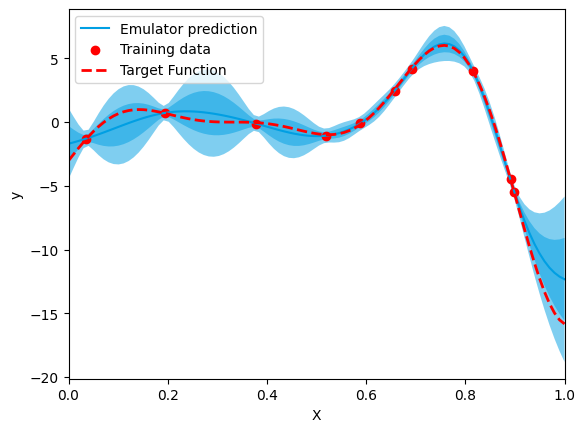

In [5]:
plt = emulator.plot(x_axis="X", y_axis="y", x_lim=(0,1))
plt.scatter(df_train["X"], df_train["y"], color="red", label="Training data")
plt.plot(X, y, c="r", linewidth=2, linestyle="dashed", label="Target Function")
plt.legend()
plt.show()

Now, we have an initial model with which we can try to sample a datapoint that the model thinks is the maxima of the objective function with its current knowledge of the hidden function(that we know in this case!). This is done by the `Emulator.recommend` function in twinLab


In [6]:
df_max = emulator.recommend(
    num_points=1, acq_func="ExpectedImprovement", verbose=True
)
df_max["y"] = f(df_max["X"].values) + np.random.normal(scale=0.1, size=1)
print(df_max)

{'message': "TypeError: ExpectedImprovement.__init__() got an unexpected keyword argument 'weights'"}


KeyError: 'dataframe not in API response body'

Plot the model's mean prediction, confidence interval, the training data and the maxima candidate for the target function that was generated by `Emulator.recommend` method.
It can be seen that the point sampled by this function is a maxima of the target function


NameError: name 'df_max' is not defined

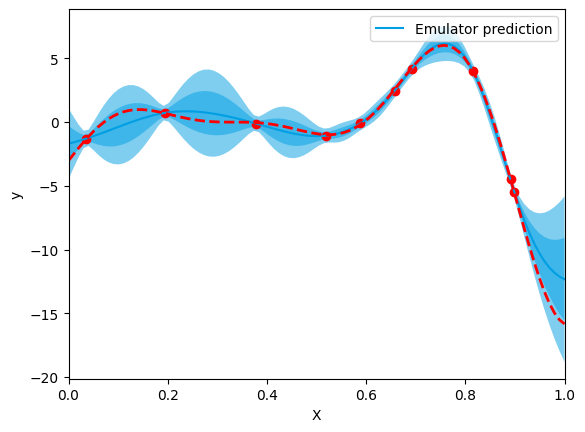

In [7]:
#Plot the results
plt = emulator.plot(x_axis="X", y_axis="y", x_lim=(0,1))
plt.scatter(df_train["X"], df_train["y"], color="red", label="Training data")
plt.plot(X, y, c="r", linewidth=2, linestyle="dashed", label="Target Function")
plt.scatter(df_max["X"], df_max["y"], color="black", label="Local maxima")
plt.legend()
plt.show()

We can optimise for this function again to extract better maxima candidates using the `Emulator.recommend` method. To do this, we just need to re-run this method again with the same model.


In [ ]:
df_max_new = emulator.recommend(num_points=1, acq_func="ExpectedImprovement")
df_max_new["y"] = f(df_max_new["X"].values) + np.random.normal(scale=0.1, size=1)
print(df_max_new)

We can once again plot the results to visualise the mean prediction of the model, the confidence interval of the model, the target function, the data points and the newly extracted candidate point for the maxima. The plots might almost look the same, and the improvement(if any) in the optimisation process can be observed from the 'y' value for the new point. Optimisation over an objective function is an iterative process. This may require running the `Emulator.recommend` method multiple times to achieve a better estimate of the maxima of the function.


In [ ]:
#Plot the results
plt = emulator.plot(x_axis="X", y_axis="y", x_lim=(0,1))
plt.scatter(df_train["X"], df_train["y"], color="red", label="Training data")
plt.plot(X, y, c="r", linewidth=2, linestyle="dashed", label="Target Function")
plt.scatter(df_max_new["X"], df_max_new["y"], color="black", label="Local maxima candidate")
plt.legend()
plt.show()

Delete the emulator and the dataset if required from the cloud.


In [ ]:
# Delete the emulator and dataset
dataset.delete()
emulator.delete()

### **2-Dimensional Example**

In the previous one-dimensional example, the model sampled a point that was a maxima of the target function. This is a very good educated guess for a maxima that the model is making given the very small number of training data points. We can now also see how this works for a 2D example.


In [8]:
# A simple 2D quadratic function
np.random.seed(20)
def quadratic(x, y):
    return -((x - 1) ** 2 + (y - 2) ** 2)


# Plotting function
def plot_function(
    xx,
    yy,
    zz,  # Background grid
    zz_pred=None,
    zz_stdv=None,  # Mean and uncertainty in model function
    x_org=None,
    y_org=None,
    z_org=None,  # Original training data
    x_max=None,
    y_max=None,  # Proposed candidate points for maxima
    show_truth=True,  # Show true function
):
    cmap_fn, cmap_std = "YlGn", "Blues"
    alpha_fn, alpha_std = 0.8, 1.0
    levels = 20
    color_org, color_max = "black", "red"
    marker_org, marker_max = "x", "o"
    marker_col = "o"
    vmin, vmax = zz.min(), zz.max()
    figx, figy = 4, 4

    # Set layout
    if zz_pred is None and zz_stdv is None:
        rows, cols = 1, 1
    else:
        rows, cols = 1, 3
    _, axs = plt.subplots(rows, cols, figsize=(cols * figx, rows * figy))

    if rows == 1 and cols == 1:
        axs = np.array([axs])
    axs = np.atleast_2d(axs)
    for ax in axs.flatten():
        ax.set_xticks([]), ax.set_yticks([])
        ax.set_aspect("equal")

    # Plot true function
    if show_truth:
        axs[0, 0].set_title("True function")
        axs[0, 0].contourf(
            xx,
            yy,
            zz,
            cmap=cmap_fn,
            levels=levels,
            alpha=alpha_fn,
            vmin=vmin,
            vmax=vmax,
        )
    else:
        axs[0, 0].set_title("True function (unknown)")
        axs[0, 0].set_facecolor("lightgrey")

    if (
        x_org is not None and y_org is not None and z_org is not None
    ):  # Plot original points
        if show_truth:
            axs[0, 0].scatter(
                x_org, y_org, c=color_org, marker=marker_org, label="Original samples"
            )
            axs[0, 1].scatter(
                x_org, y_org, c=color_org, marker=marker_org, label="Original samples"
            )
            axs[0, 2].scatter(
                x_org, y_org, c=color_org, marker=marker_org, label="Original samples"
            )
        else:
            pass
            axs[0, 0].scatter(
                x_org,
                y_org,
                c=z_org,
                marker=marker_col,
                cmap=cmap_fn,
                vmin=vmin,
                vmax=vmax,
                label="Original samples",
            )
        axs[0, 0].legend(loc="upper left")

    # Plot mean prediction
    if zz_pred is not None and zz_stdv is not None:
        axs[0, 1].set_title("Model function")
        axs[0, 1].contourf(
            xx,
            yy,
            zz_pred,
            cmap=cmap_fn,
            levels=levels,
            alpha=alpha_fn,
            vmin=vmin,
            vmax=vmax,
        )
        axs[0, 2].set_title("Model uncertainty")
        axs[0, 2].contourf(
            xx, yy, zz_stdv, cmap=cmap_std, levels=levels, alpha=alpha_std
        )
        if x_org is not None:  # Plot original points
            axs[0, 1].scatter(x_org, y_org, c=color_org, marker=marker_org)
            axs[0, 2].scatter(x_org, y_org, c=color_org, marker=marker_org)
            if rows == 2:
                axs[1, 1].scatter(x_org, y_org, c=color_org, marker=marker_org)
                axs[1, 2].scatter(x_org, y_org, c=color_org, marker=marker_org)
        if x_max is not None:  # Plot candidate points for maxima
            axs[0, 0].scatter(
                x_max, y_max, c=color_max, marker=marker_max, label="Maximum candidate"
            )
            axs[0, 1].scatter(
                x_max, y_max, c=color_max, marker=marker_max, label="Maximum candidate"
            )
            axs[0, 2].scatter(
                x_max, y_max, c=color_max, marker=marker_max, label="Maximum candidate"
            )
            axs[0, 0].legend(loc="upper left")
            axs[0, 1].legend(loc="upper left")
            axs[0, 2].legend(loc="upper left")
            if rows == 2:
                axs[1, 2].scatter(x_max, y_max, c=color_max, marker=marker_max)

    plt.tight_layout()
    plt.show()

Visualise the 2D target function. This function has a maximum at (x*, y*) = (1, 2) and f(x*, y*) = 0


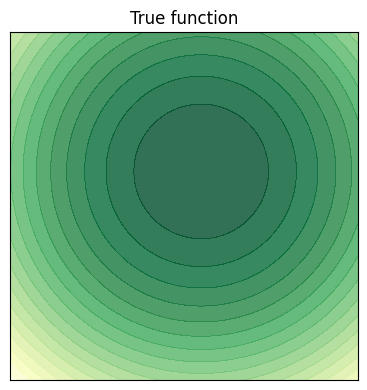

In [9]:
seed = 20
np.random.seed(seed)
nmesh = 101

# Define ranges for plotting
xmin, xmax = -10, 10
ymin, ymax = -10, 10
# Generate x and y values
xx = np.linspace(xmin, xmax, nmesh)
yy = np.linspace(ymin, ymax, nmesh)
xx, yy = np.meshgrid(xx, yy)
zz = quadratic(xx, yy)

# Generate noisy train data
n_train = 15
err = 0.1
x_train = np.random.uniform(xmin, xmax, n_train)
y_train = np.random.uniform(ymin, ymax, n_train)
z_train = np.random.normal(quadratic(x_train, y_train), err, n_train)

# Number of new data points to generate each iteration
num_points = 1

# Plot the data points
plot_function(xx, yy, zz, x_org=x_train, y_org=y_train)

# Convert to dataframes
df_train = pd.DataFrame(
    {"x": x_train.flatten(), "y": y_train.flatten(), "z": z_train.flatten()}
)
df_test = pd.DataFrame({"x": xx.flatten(), "y": yy.flatten(), "z": zz.flatten()})

Upload the training dataset


In [10]:
# Define the name of the dataset
dataset_id = "2D_Data"

# Initialise a Dataset object
dataset = tl.Dataset(id=dataset_id)

# Upload the dataset to the cloud
dataset.upload(df_train)

Initialise an emulator, train the emulator and predict on the test data


In [11]:
# Initialise emulator
emulator_id = "2D_GP"

new_emulator = tl.Emulator(id=emulator_id)

# Train the emulator
new_emulator.train(dataset=dataset, inputs=["x", "y"], outputs=["z"], verbose=True)

# Inference on test data
predictions = new_emulator.predict(df_test)
result_df = pd.concat([predictions[0], predictions[1]], axis=1)
df_mean, df_stdev = result_df.iloc[:, 0], result_df.iloc[:, 1]
z_mean, z_stdev = df_mean.values, df_stdev.values

Model 2D_GP has begun training.
Training complete!


We now try to sample a point using the `Emulator.recommend` method in twinLab and try to visualise it alongside the original training samples on 2D contours of the true function and the model function. It can be seen that the sampled candidate point is very close to the true maximum of the target function


In [ ]:
predictions = new_emulator.predict(df_test)
result_df = pd.concat([predictions[0], predictions[1]], axis=1)
df_mean, df_stdev = result_df.iloc[:, 0], result_df.iloc[:, 1]
z_mean, z_stdev = df_mean.values, df_stdev.values

x_org, y_org, z_org = df_train["x"].values, df_train["y"].values, df_train["z"].values

# Get candidate points for maxima of the true function using Emulator.recommend
df_max = new_emulator.recommend(num_points=1, acq_func="ExpectedImprovement")
df_max["z"] = quadratic(df_max["x"].values, df_max["y"].values) + np.random.normal(
    scale=0.1, size=1
)
print(df_max)


# Plot sample location
plot_function(
    xx,
    yy,
    zz,
    z_mean.reshape((nmesh, nmesh)),
    z_stdev.reshape((nmesh, nmesh)),
    x_org=x_org,
    y_org=y_org,
    z_org=z_org,
    x_max=df_max["x"].values,
    y_max=df_max["y"].values,
    show_truth=True,
)

We can optimise once again to see if we can achieve a better value for the maxima. We run the `Emulator.recommend` method again. Any improvement can be noted from the z value printed. The plots might look almost similar due to marginal changes in the values of the new candidate point obtained.


In [ ]:
# Optimise once again using Emulator.recommend
df_max_new = new_emulator.recommend(num_points=1, acq_func="ExpectedImprovement")
df_max_new["z"] = quadratic(
    df_max_new["x"].values, df_max_new["y"].values
) + np.random.normal(scale=0.1, size=1)
print(df_max_new)


# Plot sample location
plot_function(
    xx,
    yy,
    zz,
    z_mean.reshape((nmesh, nmesh)),
    z_stdev.reshape((nmesh, nmesh)),
    x_org=x_org,
    y_org=y_org,
    z_org=z_org,
    x_max=df_max_new["x"].values,
    y_max=df_max_new["y"].values,
    show_truth=True,
)

Delete the training datasets and the training emulators from the cloud if required


In [ ]:
# Delete emulator and dataset
new_emulator.delete()
dataset.delete()

